In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle
import torch as torch
import torchvision
import mongoengine
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision import datasets

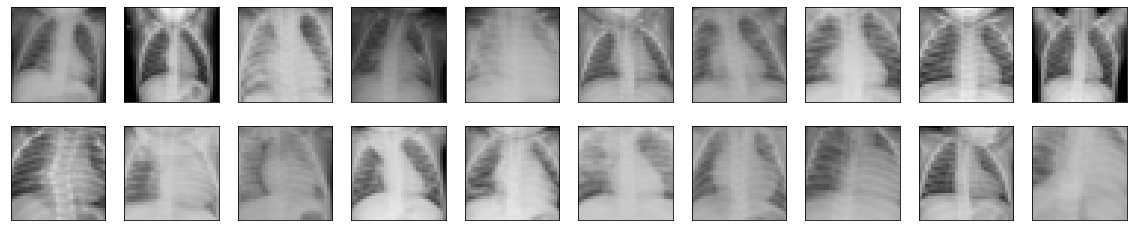

In [2]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [3]:
image_transforms = {'train': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
                  }

loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=image_transforms['train']),
                                                        batch_size=128, shuffle=True),                    
                   'valid': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/val', 
                                                                             transform=image_transforms['valid']),
                                                        batch_size=128, shuffle=True), 
                   'test': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/test', 
                                                                            transform=image_transforms['test']),
                                                        batch_size=128, shuffle=True)}

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=6272, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=412)
        self.fc4 = nn.Linear(in_features=412, out_features=2)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(F.max_pool2d(self.c1(x), 3))
        x = F.relu(F.max_pool2d(self.c2(x), 3))
        x = F.relu(F.max_pool2d(self.c3(x), 3))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


In [ ]:
model = Net()

In [ ]:
model.cuda()

Net(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=2, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
mongoengine.connect('pytorchboard')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

In [ ]:
class TrainingData(mongoengine.Document):
    date_time = mongoengine.DateTimeField(required=True)
    epoch = mongoengine.IntField()
    train_loss = mongoengine.FloatField()
    test_loss = mongoengine.FloatField()
    train_accuracy = mongoengine.FloatField()
    test_accuracy = mongoengine.FloatField()
    gradients = mongoengine.BinaryField()

In [ ]:
for epoch in range(1, 101):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0.0
    test_accuracy = 0.0
    gradients = dict()

    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss / datasets.ImageFolder('chest_xray/train', transform=image_transforms['train']).__len__()

    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['train']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    train_loss = train_loss / datasets.ImageFolder('chest_xray/train', transform=image_transforms['test']).__len__()
    train_accuracy = total_correct/total
    print('Training accuracy: {:.0%}'.format(total_correct/total))
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['valid']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    test_accuracy = total_correct/total
    print('Validation accuracy: {:.0%}'.format(total_correct/total))
    td = TrainingData(date_time=datetime.datetime.now())       
    td.epoch = epoch
    td.train_loss = train_loss
    td.test_loss = test_loss
    td.train_accuracy = train_accuracy
    td.validation_accuracy = test_accuracy
    gradients_dict = {k:v.cpu().numpy() for (k,v) in model.state_dict().items()}
    td.gradients = pickle.dumps(gradients_dict)
    td.save()
#     if total_correct/total > 0.8:
#         torch.save(model.state_dict(), 'pt/XRP_' + str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

Loss:  0.690815269947052
Loss:  0.6600399017333984
Loss:  0.6058178544044495
Loss:  0.5687176585197449
Loss:  0.5879955291748047
Loss:  0.6990935206413269
Loss:  0.6121244430541992
Loss:  0.5873472094535828
Loss:  0.5841731429100037
Loss:  0.6099420189857483
Loss:  0.6115288734436035
Loss:  0.5610635280609131
Loss:  0.5293806791305542
Loss:  0.5181272029876709
Loss:  0.4222904145717621
Loss:  0.4986377954483032
Loss:  0.49659264087677
Loss:  0.35898709297180176
Loss:  0.34549081325531006
Loss:  0.2923855781555176
Loss:  0.2591489255428314
Loss:  0.3127569854259491
Loss:  0.27009105682373047
Loss:  0.31707146763801575
Loss:  0.10536050796508789
Loss:  0.1279219388961792
Loss:  0.1831696778535843
Loss:  0.1586543172597885
Loss:  0.17579516768455505
Loss:  0.19460196793079376
Loss:  0.09793245047330856
Loss:  0.3241034746170044
Loss:  0.11397755891084671
Loss:  0.11833880096673965
Loss:  0.24868477880954742
Loss:  0.2993070185184479
Loss:  0.12104088068008423
Loss:  0.27452850341796875
Lo

Loss:  0.10142648220062256
Loss:  0.07327601313591003
Loss:  0.07987751811742783
Loss:  0.03749379888176918
Loss:  0.07004240155220032
Loss:  0.048152193427085876
Loss:  0.04066367447376251
Loss:  0.02899644337594509
Loss:  0.08487792313098907
Loss:  0.08093991130590439
Loss:  0.08044816553592682
Loss:  0.060229621827602386
Loss:  0.08329282701015472
Loss:  0.029746931046247482
Loss:  0.046289920806884766
Loss:  0.15348529815673828
Loss:  0.16709725558757782
Loss:  0.06224343553185463
Loss:  0.043776735663414
Loss:  0.10468903928995132
Loss:  0.0585368350148201
Loss:  0.08731862902641296
Loss:  0.07704617828130722
Loss:  0.03824698179960251
Loss:  0.07691588997840881
Loss:  0.07043243199586868
Loss:  0.08910216391086578
Loss:  0.07399719953536987
Loss:  0.12218251824378967
Loss:  0.08791318535804749
Loss:  0.06333420425653458
Loss:  0.11145421117544174
Training accuracy: 97%
Loss:  1.2363003492355347
Validation accuracy: 62%
Loss:  0.08145422488451004
Loss:  0.13544033467769623
Loss:  

Loss:  0.09407815337181091
Loss:  0.042327072471380234
Loss:  0.04340040311217308
Loss:  0.027246907353401184
Loss:  0.03340549394488335
Loss:  0.04556620866060257
Loss:  0.02191336825489998
Loss:  0.023262247443199158
Loss:  0.0456402525305748
Loss:  0.012691096402704716
Loss:  0.05103008449077606
Loss:  0.018117103725671768
Loss:  0.10578465461730957
Loss:  0.015025006607174873
Loss:  0.07171940803527832
Loss:  0.09381824731826782
Loss:  0.09780833125114441
Loss:  0.0628981739282608
Loss:  0.030395079404115677
Loss:  0.06150955706834793
Loss:  0.06326456367969513
Loss:  0.03114447370171547
Loss:  0.03163960576057434
Loss:  0.03382866829633713
Loss:  0.03658842295408249
Loss:  0.04795818030834198
Loss:  0.05861479789018631
Loss:  0.016973912715911865
Loss:  0.0333792120218277
Epoch:  8
Loss:  0.044707026332616806
Loss:  0.07078660279512405
Loss:  0.09923850744962692
Loss:  0.06520316004753113
Loss:  0.03024628758430481
Loss:  0.09774424135684967
Loss:  0.03366570547223091
Loss:  0.053

Loss:  0.01956394873559475
Loss:  0.009516088292002678
Loss:  0.04472615569829941
Loss:  0.028274662792682648
Loss:  0.03500628098845482
Loss:  0.05932319536805153
Loss:  0.022689171135425568
Loss:  0.0657065212726593
Loss:  0.038102224469184875
Loss:  0.04133106395602226
Loss:  0.08584664762020111
Loss:  0.09631258249282837
Loss:  0.01814018376171589
Loss:  0.05081263184547424
Loss:  0.09404801577329636
Loss:  0.030605634674429893
Loss:  0.0256260484457016
Loss:  0.02718154899775982
Loss:  0.0023263394832611084
Loss:  0.031416118144989014
Loss:  0.05603518337011337
Loss:  0.02800767868757248
Loss:  0.04214823991060257
Loss:  0.004241535905748606
Loss:  0.05823595076799393
Loss:  0.05688323825597763
Loss:  0.02920708991587162
Training accuracy: 99%
Loss:  1.9411195516586304
Validation accuracy: 62%
Loss:  0.07460454851388931
Loss:  0.07439897954463959
Loss:  0.02922758087515831
Loss:  0.011995935812592506
Loss:  0.012116254307329655
Loss:  0.06844072043895721
Loss:  0.08468509465456009

Loss:  0.0710144191980362
Loss:  0.044141627848148346
Loss:  0.026464173570275307
Loss:  0.008570042438805103
Loss:  0.03805001825094223
Loss:  0.007033067289739847
Loss:  0.007108527701348066
Loss:  0.03464557230472565
Loss:  0.022198379039764404
Loss:  0.014107857830822468
Loss:  0.003549790009856224
Loss:  0.006914067547768354
Loss:  0.04467951878905296
Loss:  0.012625264003872871
Loss:  0.006718796212226152
Loss:  0.009731071069836617
Loss:  0.002003086730837822
Loss:  0.0158823374658823
Loss:  0.006571365986019373
Loss:  0.0038622424472123384
Loss:  0.007559056859463453
Loss:  0.002497671637684107
Loss:  0.011494666337966919
Loss:  0.005774777382612228
Loss:  0.00677972286939621
Loss:  0.0013834396377205849
Loss:  0.004472583532333374
Loss:  0.0073319412767887115
Loss:  0.01666858047246933
Epoch:  15
Loss:  0.0035926662385463715
Loss:  0.0007908279076218605
Loss:  0.0018798206001520157
Loss:  0.0022776182740926743
Loss:  0.0042345887050032616
Loss:  0.0029494110494852066
Loss:  0.

Loss:  0.0017598890699446201
Loss:  0.009269881062209606
Loss:  0.0009909477084875107
Loss:  0.0013847444206476212
Loss:  0.0023081242106854916
Loss:  0.0030908845365047455
Loss:  0.008316545747220516
Loss:  0.003674074076116085
Loss:  0.0060050394386053085
Loss:  0.0025823877658694983
Loss:  0.0015873382799327374
Loss:  0.021039877086877823
Loss:  0.0006525330245494843
Loss:  0.0035317479632794857
Loss:  0.0051255617290735245
Loss:  0.0019579255022108555
Loss:  0.004248568322509527
Loss:  0.027626177296042442
Loss:  0.0011146273463964462
Loss:  0.0007016249001026154
Loss:  0.002574182115495205
Loss:  0.0016714558005332947
Loss:  0.0008882991969585419
Loss:  0.0014452803879976273
Loss:  0.0010108556598424911
Loss:  0.016532890498638153
Loss:  0.004182689823210239
Loss:  0.012255745008587837
Loss:  0.0035891595762223005
Loss:  0.0012666583061218262
Loss:  0.0012202169746160507
Loss:  0.0005467487499117851
Loss:  0.003707721596583724
Loss:  0.03171316161751747
Loss:  0.001795854419469833

Loss:  0.0010416097939014435
Training accuracy: 100%
Loss:  0.4545381963253021
Validation accuracy: 75%
Loss:  0.0010308893397450447
Loss:  0.00843752920627594
Loss:  0.007780564017593861
Loss:  0.0012201741337776184
Loss:  0.00023452844470739365
Loss:  0.0027661658823490143
Loss:  0.0009152349084615707
Loss:  0.03229444473981857
Loss:  0.0018808520399034023
Loss:  0.00035011954605579376
Loss:  0.0009452644735574722
Loss:  0.002212654799222946
Loss:  0.01088695041835308
Loss:  0.010005286894738674
Loss:  0.00019957497715950012
Loss:  0.000372578389942646
Loss:  0.0016341060400009155
Loss:  0.0005612941458821297
Loss:  0.040236249566078186
Loss:  0.0009071556851267815
Loss:  0.00014678016304969788
Loss:  0.003544146427884698
Loss:  0.014965444803237915
Loss:  0.004792953375726938
Loss:  0.0005327304825186729
Loss:  0.0016884184442460537
Loss:  0.032172299921512604
Loss:  0.0024179918691515923
Loss:  0.0004335697740316391
Loss:  0.00047829654067754745
Loss:  0.0024560592137277126
Loss:  

Loss:  5.552731454372406e-05
Loss:  0.0002487068995833397
Loss:  2.6535242795944214e-05
Loss:  0.0005501070991158485
Loss:  5.9079378843307495e-05
Loss:  8.076988160610199e-05
Loss:  0.00017965584993362427
Loss:  1.6320496797561646e-05
Loss:  0.00018293783068656921
Loss:  0.00015872810035943985
Loss:  3.526173532009125e-05
Loss:  0.0001424737274646759
Loss:  7.813796401023865e-05
Loss:  0.00017258338630199432
Loss:  0.00021136179566383362
Loss:  8.06804746389389e-05
Loss:  7.467903196811676e-05
Loss:  3.481904786895029e-05
Epoch:  25
Loss:  7.223151624202728e-05
Loss:  7.554516196250916e-05
Loss:  6.363168358802795e-05
Loss:  9.231269359588623e-05
Loss:  3.997981548309326e-05
Loss:  1.2954697012901306e-05
Loss:  4.945322871208191e-05
Loss:  1.9399449229240417e-05
Loss:  6.760656833648682e-05
Loss:  1.358427107334137e-05
Loss:  0.00020284578204154968
Loss:  5.978532135486603e-05
Loss:  4.5048072934150696e-05
Loss:  0.0001704879105091095
Loss:  4.623830318450928e-05
Loss:  4.579685628414

Loss:  6.838329136371613e-05
Loss:  3.376416862010956e-05
Loss:  3.9381906390190125e-05
Loss:  3.218837082386017e-05
Loss:  1.270882785320282e-05
Loss:  7.324293255805969e-05
Loss:  6.755813956260681e-06
Loss:  1.3379380106925964e-05
Loss:  1.1453405022621155e-05
Loss:  4.988163709640503e-05
Loss:  1.560710370540619e-05
Loss:  3.102794289588928e-05
Loss:  5.5655837059021e-06
Loss:  5.187466740608215e-05
Loss:  2.954155206680298e-06
Loss:  4.283711314201355e-05
Loss:  1.881830394268036e-05
Loss:  3.8662925362586975e-05
Loss:  1.2880191206932068e-05
Loss:  6.5656378865242e-05
Loss:  2.1513551473617554e-05
Loss:  3.653764724731445e-05
Loss:  2.339296042919159e-05
Loss:  4.040636122226715e-05
Loss:  2.989731729030609e-05
Loss:  1.2045726180076599e-05
Loss:  6.975606083869934e-06
Loss:  4.961155354976654e-05
Loss:  2.2960826754570007e-05
Loss:  1.4990568161010742e-05
Loss:  1.298077404499054e-05
Loss:  2.372823655605316e-05
Loss:  7.392279803752899e-05
Loss:  1.9511207938194275e-05
Loss:  1

Loss:  1.4934688806533813e-05
Loss:  9.978190064430237e-06
Loss:  1.2749806046485901e-05
Loss:  1.6925856471061707e-05
Loss:  4.980713129043579e-06
Loss:  3.0100345611572266e-06
Loss:  1.0933727025985718e-05
Loss:  5.5108219385147095e-05
Loss:  3.388151526451111e-05
Loss:  5.668029189109802e-06
Loss:  4.721805453300476e-06
Loss:  1.348927617073059e-05
Loss:  9.86953546089353e-06
Training accuracy: 100%
Loss:  1.7802376747131348
Validation accuracy: 81%
Loss:  1.8166378140449524e-05
Loss:  5.6939199566841125e-05
Loss:  1.3580545783042908e-05
Loss:  4.289671778678894e-06
Loss:  5.462951958179474e-05
Loss:  9.734183549880981e-06
Loss:  3.512948751449585e-06
Loss:  7.253140211105347e-06
Loss:  1.928582787513733e-05
Loss:  1.6314908862113953e-05
Loss:  6.703659892082214e-06
Loss:  1.4277175068855286e-05
Loss:  2.7494505047798157e-05
Loss:  2.8505921363830566e-05
Loss:  8.480623364448547e-06
Loss:  9.121373295783997e-06
Loss:  5.416572093963623e-06
Loss:  1.5217810869216919e-05
Loss:  8.0186

Loss:  2.2882595658302307e-05
Loss:  2.0489096641540527e-06
Loss:  6.023794412612915e-06
Loss:  2.2416934370994568e-05
Loss:  1.0522082448005676e-05
Loss:  1.961737871170044e-05
Loss:  7.227063179016113e-06
Loss:  1.3597309589385986e-05
Loss:  1.8483027815818787e-05
Loss:  1.4727935194969177e-05
Loss:  1.3438984751701355e-05
Loss:  1.385621726512909e-05
Loss:  4.464760422706604e-06
Loss:  7.927417755126953e-06
Loss:  1.1458992958068848e-05
Loss:  2.765469253063202e-05
Loss:  3.948807716369629e-06
Loss:  3.399699926376343e-05
Loss:  2.1276995539665222e-05
Loss:  5.185604095458984e-06
Loss:  3.032386302947998e-06
Loss:  1.0382384061813354e-05
Loss:  3.9987266063690186e-05
Loss:  2.8703361749649048e-05
Loss:  8.715316653251648e-06
Loss:  8.217990398406982e-06
Loss:  1.2023374438285828e-05
Loss:  4.556030035018921e-06
Loss:  2.291053533554077e-05
Loss:  3.5706907510757446e-06
Loss:  4.716217517852783e-06
Loss:  8.903443813323975e-07
Loss:  6.38266419628053e-06
Epoch:  35
Loss:  1.263804733

Loss:  1.3709068298339844e-06
Loss:  5.552545189857483e-06
Loss:  6.3497573137283325e-06
Loss:  4.2673200368881226e-06
Loss:  1.401267945766449e-05
Loss:  1.0836869478225708e-05
Loss:  4.455447196960449e-06
Loss:  1.821480691432953e-05
Loss:  1.5904506653896533e-05
Epoch:  38
Loss:  7.33695924282074e-06
Loss:  1.0661780834197998e-05
Loss:  3.084540367126465e-06
Loss:  6.3087791204452515e-06
Loss:  3.2141804695129395e-05
Loss:  2.137012779712677e-05
Loss:  7.601454854011536e-06
Loss:  2.131424844264984e-05
Loss:  2.298504114151001e-06
Loss:  1.1105090379714966e-05
Loss:  3.1385570764541626e-06
Loss:  3.946945071220398e-06
Loss:  3.680586814880371e-06
Loss:  1.989305019378662e-06
Loss:  2.7194619178771973e-05
Loss:  3.7159770727157593e-06
Loss:  4.7050416469573975e-06
Loss:  2.5853514671325684e-06
Loss:  4.9211084842681885e-06
Loss:  9.164214134216309e-06
Loss:  3.417953848838806e-06
Loss:  9.000301361083984e-06
Loss:  7.202848792076111e-06
Loss:  3.825873136520386e-06
Loss:  2.603977918

Loss:  6.288290023803711e-06
Loss:  5.446374416351318e-06
Loss:  6.765127182006836e-06
Loss:  7.929280400276184e-06
Loss:  3.850087523460388e-06
Loss:  4.8857182264328e-06
Loss:  6.413087248802185e-06
Loss:  2.023950219154358e-05
Loss:  3.734603524208069e-06
Loss:  1.1593103408813477e-05
Loss:  4.023313522338867e-06
Loss:  1.895800232887268e-05
Loss:  3.2391399145126343e-06
Loss:  2.477318048477173e-06
Loss:  3.0584633350372314e-06
Loss:  1.7102807760238647e-05
Loss:  5.930662155151367e-06
Loss:  2.473779022693634e-05
Loss:  3.0938535928726196e-06
Loss:  3.857538104057312e-06
Loss:  7.739290595054626e-06
Loss:  5.692243576049805e-06
Loss:  1.5459954738616943e-06
Loss:  1.2272968888282776e-05
Loss:  4.017725586891174e-06
Loss:  1.0232130307485932e-06
Training accuracy: 100%
Loss:  1.9216629266738892
Validation accuracy: 81%
Loss:  6.3963234424591064e-06
Loss:  5.435198545455933e-06
Loss:  1.150369644165039e-05
Loss:  7.852911949157715e-06
Loss:  1.3150274753570557e-06
Loss:  6.437301635

Loss:  3.112480044364929e-06
Loss:  1.074373722076416e-05
Training accuracy: 100%
Loss:  1.9478791952133179
Validation accuracy: 81%
Loss:  1.2207776308059692e-05
Loss:  1.4098361134529114e-05
Loss:  2.678483724594116e-06
Loss:  8.588656783103943e-06
Loss:  1.5906989574432373e-06
Loss:  1.3638287782669067e-05
Loss:  4.7013163566589355e-06
Loss:  8.745118975639343e-06
Loss:  6.891787052154541e-07
Loss:  5.695968866348267e-06
Loss:  6.673857569694519e-06
Loss:  1.1537224054336548e-05
Loss:  1.300126314163208e-06
Loss:  3.7103891372680664e-06
Loss:  1.2405216693878174e-06
Loss:  5.600973963737488e-06
Loss:  4.190951585769653e-06
Loss:  2.902001142501831e-06
Loss:  6.254762411117554e-06
Loss:  1.0244548320770264e-06
Loss:  1.9297003746032715e-06
Loss:  8.568167686462402e-07
Loss:  7.599592208862305e-07
Loss:  4.844740033149719e-06
Loss:  1.3224780559539795e-06
Loss:  1.5385448932647705e-06
Loss:  1.5832483768463135e-06
Loss:  9.188428521156311e-06
Loss:  1.944601535797119e-06
Loss:  4.2822

Loss:  1.3319775462150574e-05
Loss:  2.853572368621826e-06
Loss:  8.376315236091614e-06
Loss:  9.760260581970215e-07
Loss:  3.5855919122695923e-06
Loss:  4.069879651069641e-06
Loss:  3.725290298461914e-07
Loss:  6.467103958129883e-06
Loss:  9.702518582344055e-06
Loss:  1.3083219528198242e-05
Loss:  1.3597309589385986e-06
Loss:  2.123415470123291e-07
Loss:  1.5534460544586182e-06
Loss:  3.5651028156280518e-06
Loss:  3.1962990760803223e-06
Loss:  3.825873136520386e-06
Loss:  2.773478627204895e-06
Loss:  2.730637788772583e-06
Loss:  2.2426247596740723e-06
Loss:  3.373250365257263e-06
Loss:  9.715557098388672e-06
Loss:  3.697971578731085e-06
Epoch:  48
Loss:  5.474314093589783e-06
Loss:  4.852190613746643e-06
Loss:  1.0190531611442566e-05
Loss:  1.0766088962554932e-06
Loss:  1.2679025530815125e-05
Loss:  8.456408977508545e-07
Loss:  5.960464477539062e-07
Loss:  2.980232238769531e-07
Loss:  2.1792948246002197e-06
Loss:  3.1869858503341675e-06
Loss:  6.221234798431396e-07
Loss:  1.0846182703

Loss:  8.456408977508545e-07
Loss:  5.5693089962005615e-06
Loss:  3.650784492492676e-07
Loss:  5.198642611503601e-06
Loss:  4.842877388000488e-07
Loss:  2.594664692878723e-06
Loss:  1.3615936040878296e-06
Loss:  1.8868595361709595e-06
Loss:  8.121132850646973e-07
Loss:  1.3969838619232178e-06
Loss:  6.4820051193237305e-06
Loss:  4.805624485015869e-07
Loss:  1.344829797744751e-06
Loss:  5.736947059631348e-07
Loss:  2.980232238769531e-07
Loss:  2.868473529815674e-06
Loss:  1.1809170246124268e-06
Loss:  1.5534460544586182e-06
Loss:  4.172325134277344e-07
Loss:  9.164214134216309e-07
Loss:  2.4959444999694824e-07
Loss:  5.774199962615967e-07
Loss:  4.366040229797363e-06
Loss:  1.044943928718567e-06
Loss:  1.6801059246063232e-06
Loss:  1.0561197996139526e-06
Loss:  1.0766088962554932e-06
Loss:  3.8370490074157715e-06
Loss:  5.027279257774353e-06
Loss:  2.479180693626404e-06
Loss:  1.4081597328186035e-06
Loss:  9.201467037200928e-07
Loss:  3.203749656677246e-07
Loss:  9.888783097267151e-06
L

Loss:  1.0058283805847168e-07
Loss:  3.2782554626464844e-07
Loss:  2.08243727684021e-06
Loss:  1.1436641216278076e-06
Loss:  6.668269634246826e-07
Loss:  4.0978193283081055e-07
Loss:  1.7434358596801758e-06
Loss:  2.980232238769531e-07
Loss:  3.129243850708008e-07
Loss:  1.0766088962554932e-06
Loss:  2.4605542421340942e-06
Loss:  9.98377799987793e-07
Loss:  1.1920928955078125e-07
Loss:  2.682209014892578e-07
Loss:  2.0811955891986145e-06
Training accuracy: 100%
Loss:  2.093733787536621
Validation accuracy: 81%
Loss:  7.748603820800781e-07
Loss:  1.996755599975586e-06
Loss:  6.221234798431396e-07
Loss:  8.344650268554688e-07
Loss:  8.828938007354736e-07
Loss:  8.754432201385498e-07
Loss:  2.0489096641540527e-07
Loss:  3.563240170478821e-06
Loss:  1.6540288925170898e-06
Loss:  9.611248970031738e-07
Loss:  2.5704503059387207e-07
Loss:  2.60770320892334e-07
Loss:  5.103647708892822e-07
Loss:  5.140900611877441e-07
Loss:  4.4330954551696777e-07
Loss:  4.6193599700927734e-07
Loss:  1.6018748

Loss:  1.7136335372924805e-07
Loss:  5.21540641784668e-08
Loss:  1.9371509552001953e-07
Loss:  1.4603137969970703e-06
Loss:  3.8743019104003906e-07
Loss:  1.9371509552001953e-07
Loss:  1.650303602218628e-06
Loss:  9.313225746154785e-08
Loss:  8.67992639541626e-07
Loss:  6.109476089477539e-07
Loss:  1.7043203115463257e-06
Loss:  1.0095536708831787e-06
Loss:  9.685754776000977e-08
Loss:  1.3783574104309082e-07
Loss:  1.043081283569336e-07
Loss:  2.2351741790771484e-08
Loss:  5.587935447692871e-08
Loss:  6.817281246185303e-07
Loss:  3.3527612686157227e-07
Loss:  1.8998980522155762e-07
Loss:  5.513429641723633e-07
Loss:  2.3543834686279297e-06
Loss:  7.450580596923828e-08
Loss:  4.3213367462158203e-07
Loss:  7.450580596923828e-08
Loss:  1.210719347000122e-06
Loss:  3.2782554626464844e-07
Loss:  2.25752592086792e-06
Loss:  9.685754776000977e-08
Loss:  2.5331974029541016e-07
Loss:  2.868473529815674e-07
Loss:  3.0174851417541504e-07
Loss:  1.862645149230957e-07
Loss:  2.980232238769531e-07
E

Loss:  1.8998980522155762e-07
Loss:  3.5762786865234375e-07
Loss:  1.30385160446167e-07
Loss:  6.705522537231445e-08
Loss:  2.2724270820617676e-07
Loss:  7.525086402893066e-07
Loss:  1.043081283569336e-07
Loss:  3.46451997756958e-07
Loss:  1.2293457984924316e-07
Loss:  8.44399110633276e-08
Epoch:  61
Loss:  2.6542693376541138e-06
Loss:  9.350478649139404e-07
Loss:  2.0116567611694336e-07
Loss:  2.60770320892334e-08
Loss:  5.587935447692871e-07
Loss:  2.868473529815674e-07
Loss:  1.0803341865539551e-07
Loss:  5.774199962615967e-07
Loss:  1.6391277313232422e-07
Loss:  7.078051567077637e-08
Loss:  8.195638656616211e-08
Loss:  2.2724270820617676e-07
Loss:  1.341104507446289e-07
Loss:  2.0116567611694336e-07
Loss:  6.92903995513916e-07
Loss:  1.1771917343139648e-06
Loss:  3.203749656677246e-07
Loss:  5.960464477539063e-08
Loss:  2.682209014892578e-07
Loss:  5.21540641784668e-08
Loss:  1.1175870895385742e-07
Loss:  7.82310962677002e-08
Loss:  4.023313522338867e-07
Loss:  1.1175870895385742e-

Loss:  7.227063179016113e-07
Loss:  1.5273690223693848e-07
Loss:  5.476176738739014e-07
Loss:  2.5331974029541016e-07
Loss:  5.587935447692871e-08
Loss:  1.1548399925231934e-07
Loss:  9.313225746154785e-08
Loss:  5.960464477539063e-08
Loss:  4.0978193283081055e-07
Loss:  8.568167686462402e-08
Loss:  1.4156103134155273e-07
Loss:  2.384185791015625e-07
Loss:  7.078051567077637e-08
Loss:  5.21540641784668e-08
Loss:  4.4330954551696777e-07
Loss:  7.82310962677002e-08
Loss:  1.2665987014770508e-07
Loss:  7.450580596923828e-08
Loss:  2.60770320892334e-08
Loss:  1.4528632164001465e-07
Loss:  9.313225746154785e-08
Loss:  3.0174851417541504e-07
Loss:  8.754432201385498e-07
Loss:  1.1548399925231934e-07
Loss:  2.942979335784912e-07
Loss:  1.5813857316970825e-06
Loss:  4.42067772610244e-07
Training accuracy: 100%
Loss:  2.248647928237915
Validation accuracy: 81%
Loss:  8.568167686462402e-08
Loss:  2.60770320892334e-08
Loss:  1.043081283569336e-07
Loss:  2.2351741790771484e-07
Loss:  2.98023223876

Loss:  8.67992639541626e-07
Loss:  1.7117708921432495e-06
Loss:  1.9868215517249155e-08
Training accuracy: 100%
Loss:  2.28098726272583
Validation accuracy: 81%
Loss:  3.725290298461914e-07
Loss:  1.30385160446167e-07
Loss:  6.705522537231445e-08
Loss:  4.0978193283081055e-07
Loss:  1.601874828338623e-07
Loss:  1.039355993270874e-06
Loss:  1.0803341865539551e-07
Loss:  1.1548399925231934e-06
Loss:  1.2665987014770508e-07
Loss:  5.811452865600586e-07
Loss:  1.4528632164001465e-07
Loss:  9.313225746154785e-08
Loss:  1.1175870895385742e-08
Loss:  2.421438694000244e-07
Loss:  4.0978193283081055e-08
Loss:  8.419156074523926e-07
Loss:  1.0803341865539551e-07
Loss:  2.123415470123291e-07
Loss:  8.940696716308594e-08
Loss:  3.725290298461914e-08
Loss:  2.682209014892578e-07
Loss:  1.7881393432617188e-07
Loss:  2.0116567611694336e-07
Loss:  5.960464477539063e-08
Loss:  8.195638656616211e-08
Loss:  4.954636096954346e-07
Loss:  8.195638656616211e-08
Loss:  4.731118679046631e-07
Loss:  5.140900611

Loss:  8.195638656616211e-08
Loss:  1.4901161193847656e-07
Loss:  1.2665987014770508e-07
Loss:  1.4528632164001465e-07
Loss:  1.1548399925231934e-07
Loss:  1.4901161193847656e-08
Loss:  2.0116567611694336e-07
Loss:  2.2351741790771484e-08
Loss:  4.6193599700927734e-07
Loss:  1.862645149230957e-08
Loss:  2.2351741790771484e-07
Loss:  2.2351741790771484e-07
Loss:  4.246830940246582e-07
Loss:  2.60770320892334e-08
Loss:  1.341104507446289e-07
Loss:  5.885958671569824e-07
Loss:  2.7567148208618164e-07
Loss:  1.6391277313232422e-07
Loss:  5.662441253662109e-07
Loss:  6.332993507385254e-08
Loss:  9.313225746154785e-08
Loss:  5.960464477539063e-08
Epoch:  71
Loss:  1.6763806343078613e-07
Loss:  8.195638656616211e-08
Loss:  5.587935447692871e-08
Loss:  2.4959444999694824e-07
Loss:  1.1175870895385742e-07
Loss:  8.568167686462402e-08
Loss:  2.2351741790771484e-08
Loss:  4.0978193283081055e-08
Loss:  4.0978193283081055e-08
Loss:  1.4156103134155273e-07
Loss:  2.60770320892334e-08
Loss:  6.705522

numpy.ndarray